# Phase Unwrapping

> phase unwrapping

In [ ]:
#| default_exp pu

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math
import numpy as np
import tempfile
from pathlib import Path
import os
from moraine.gamma_ import read_gamma_pdata, read_gamma_plist, write_gamma_image, write_gamma_plist

In [ ]:
import zarr
import moraine as mr

In [ ]:
#| export
def gamma_mcf_pt(
    pc_x:np.ndarray, # x coordinate, shape of (N,)
    pc_y:np.ndarray, # y coordinate, shape of (N,)
    ph:np.ndarray, # wrapped phase, shape of (N,) or (N,M)
    ph_weight:np.ndarray=None, # point weight, shape of (N,) or (N,M), optional
    ref_point:int=1, # reference point, the first point by default
) -> np.ndarray: # unwrapped phase, shape of (N,) or (N,M)
    '''A simple wrapper for mcf_pt in GAMMA software.'''
    pc_x = pc_x.astype(np.int32)
    pc_y = pc_y.astype(np.int32)
    pc_xy = np.stack((pc_x,pc_y),axis=-1)
    ph = ph.astype(np.complex64)

    with tempfile.TemporaryDirectory() as tempdir_str:
        temp_dir = Path(tempdir_str)
        pc_path = temp_dir/'pc'
        ph_path = temp_dir/'ph'
        unwrap_ph_path = temp_dir/'unwrap_ph'
        write_gamma_plist(pc_xy,pc_path)
        write_gamma_image(ph,ph_path)
        if ph_weight is None:
            ph_weight_path = '-'
        else:
            ph_weight_path = temp_dir/'ph_weight'
            ph_wieght = ph_weight.astype(np.float32)
            write_gamma_image(ph_weight,ph_weight_path)
        
        mcf_pt_command = f'mcf_pt {str(pc_path)} - {str(ph_path)} - {str(ph_weight_path)} - {str(unwrap_ph_path)} - - {ref_point} &> {temp_dir/"gamma.log"}'
        os.system(mcf_pt_command)

        unwrap_ph = read_gamma_pdata(unwrap_ph_path,dtype='float')
        unwrap_ph = unwrap_ph.reshape(ph.shape)
    return unwrap_ph

usage:

In [ ]:
rslc = zarr.open('../../data/rslc.zarr/','r')[:]

# SHP selection
az_half_win = 5; r_half_win = 5
az_win = 2*az_half_win+1; r_win = 2*r_half_win+1

rmli = np.abs(rslc)**2
p = mr.ks_test(rmli,az_half_win=az_half_win,r_half_win=r_half_win)
is_shp = p < 0.05

# Select DS candidate
shp_num = np.count_nonzero(is_shp,axis=(-2,-1))
is_ds_can = shp_num >= 50

ds_can_is_shp = is_shp[is_ds_can]
ds_can_gix = np.stack(np.where(is_ds_can),axis=-1)
ds_can_ph, ds_can_emi_quality, ds_can_t_coh = mr.emperical_co_emi_temp_coh_pc(rslc,ds_can_gix,ds_can_is_shp,batch_size=1000)

_is_ds_can_refined = (ds_can_emi_quality>=1.0) & (ds_can_emi_quality <1.2) & (ds_can_t_coh > 0.7) & (ds_can_t_coh <= 1.0)

ds_gix = ds_can_gix[_is_ds_can_refined]
ds_ph = ds_can_ph[_is_ds_can_refined]

ds_hix = mr.pc_hix(ds_gix,shape=rslc.shape[:2])
hix_sort_key = mr.pc_sort(ds_hix)

ds_hix = ds_hix[hix_sort_key]
ds_gix = ds_gix[hix_sort_key]
ds_ph = ds_ph[hix_sort_key]

e = zarr.open('../../data/e.zarr/','r')[:]
n = zarr.open('../../data/n.zarr/','r')[:]

ds_e = mr.ras2pc(e,ds_gix)
ds_n = mr.ras2pc(n,ds_gix)

ds_ph = ds_ph*ds_ph[:,0:1].conj() # set the first image as secondary

Unwrap one single interferogram:

In [ ]:
ds_ph_ = ds_ph[:,14]*ds_ph[:,9].conj()

unw = gamma_mcf_pt(ds_e, ds_n, ds_ph_)

In [ ]:
def wrap(unw):
    return np.mod(unw + np.pi, 2 * np.pi) - np.pi

In [ ]:
np.testing.assert_array_almost_equal(wrap(unw),np.angle(ds_ph_),decimal=4)

Unwrap multiple interferograms:

In [ ]:
unw2 = gamma_mcf_pt(ds_e, ds_n, ds_ph[:,2:4])
np.testing.assert_array_almost_equal(wrap(unw2),np.angle(ds_ph[:,2:4]),decimal=4)

In [ ]:
import holoviews as hv
import datashader as ds
import spatialpandas
import zarr
import numpy as np
from holoviews import opts
from bokeh.models import WheelZoomTool

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
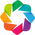

In [ ]:
hv.extension('bokeh')

In [ ]:
coordinates = spatialpandas.geometry.PointArray((ds_e, ds_n))
data = spatialpandas.GeoDataFrame({'geometry':coordinates,'phase':unw})
unw_plot = mr.points(data,kdims=['e','n'],pdim='phase',google_earth=True)

coordinates = spatialpandas.geometry.PointArray((ds_e, ds_n))
data = spatialpandas.GeoDataFrame({'geometry':coordinates,'phase':np.angle(ds_ph_)})
ph_plot = mr.points(data,kdims=['e','n'],pdim='phase',prange=(-np.pi,np.pi),google_earth=True)

In [ ]:
unw_plot.opts(opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True, xlabel='Longitude', ylabel='Latitude'),
          opts.Points(marker='o',size=10,tools=['hover']))

:DynamicMap   []
   :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Image.I  :Image   [e,n]   (phase)
      .Points.I :Points   [e,n]   (phase)

In [ ]:
ph_plot.opts(opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True, xlabel='Longitude', ylabel='Latitude'),
          opts.Points(marker='o',size=10,tools=['hover']))

:DynamicMap   []
   :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Image.I  :Image   [e,n]   (phase)
      .Points.I :Points   [e,n]   (phase)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()